### Best found individual models

OS: Using an oversampling technique (adasyn or smote)
- Naive Bayes
- (OS)Lineal discriminant Analysis using  hyperparameters:
  - least squares function 'lsqr'
- (OS)Logistic regresion using  hyperparameters:
  - solver    newton-cg
  - param_C   low regularization     0.7!
- Decision Trees
  - param_criterion                            gini,(os)entropy
  - param_min_weight_fraction_leaf                   0
  - param_max_features                            None
  - param_class_weight                {0: 0.2, 1: 1.0}
  - param_max_depth                                  5
- SVC
  
#### can i use cv insede a piline?
- so try PCA, ICA Etc 
- with and without OS

- also dadboost and random forests

In [121]:
import time
import pandas as pd
from pandas import scatter_matrix
import numpy as np
import sklearn
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA, FastICA

from imblearn.over_sampling import SMOTE, ADASYN

from random import randint

%matplotlib inline

In [122]:
data_iono = pd.read_csv("/home/wanda/master_project/Data/spain_balance_data.csv",index_col=0)
data_spain = data_iono[data_iono.network=='rap']
data_iono = data_iono[data_iono.network!='rap']

metadata = ['prn','network','STATIONS','PAIRS', 'ID','YEAR', 'DAY','TIME' ]
labels = ['BIN_LABEL' 'LABEL']
columns = ['A_index', 'C_flare', 'K_index', 'N_PAIRS', 'N_STATIONS',
       'kurtosis_delay', 'kurtosis_grad', 'max_elevation', 'max_grad',
       'max_phase_delay', 'mean_code_delay', 'mean_elevation', 'mean_grad',
       'mean_phase_delay', 'min_elevation', 'min_grad', 'min_phase_delay',
       'mse', 'new_regions', 'radio_flux', 'std_grad', 'std_phase',
       'sunsplot_number', 'sunspot_area', 'bucket_grad',
       'bucket_grad_mean', 'k_index_bucket', 'elev_min_bucket',
       'elev_mean_bucket', 'elev_max_bucket', 'grad_elev']

X = data_iono[columns]
X_spain = data_spain[columns]

print "Dataset shape: ",X.shape
print "Dataset (Spain) shape: ",X_spain.shape
y_bin, y_classes = data_iono.BIN_LABEL, data_iono.LABEL
y_spain = data_spain.BIN_LABEL


def fnr_score(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    tp = cm[1][1]*1.
    fn = cm[1][0]*1.
    tn = cm[0][0]*1.
    fp = cm[0][1]*1.
    fnr = fn/(tp+fn)
    return fnr

def fpr_score(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    tp = cm[1][1]*1.
    fn = cm[1][0]*1.
    tn = cm[0][0]*1.
    fp = cm[0][1]*1.
    fpr = fp/(tn+fp)
    return fpr

def for_score(y, y_pred):
    #false omission rate
    cm = confusion_matrix(y, y_pred)
    tp = cm[1][1]*1.
    fn = cm[1][0]*1.
    tn = cm[0][0]*1.
    fp = cm[0][1]*1.
    fpr = fn/(tn+fn)
    return fpr

f2_scorer = make_scorer(fbeta_score, beta=2)
fnr_scorer = make_scorer(fnr_score)
fpr_scorer = make_scorer(fpr_score)
for_scorer = make_scorer(for_score)
recall_scorer = make_scorer(recall_score)


def train_test_cv(clf,X,y,test_size,folds):
    X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=test_size, random_state=randint(1,100), stratify= y_bin)
    cv = StratifiedKFold(n_splits=folds, random_state=randint(1,100), shuffle=True)
    scores_f2 = cross_val_score(clf, X_train,y_train,cv=cv,scoring=f2_scorer)
    scores_tpr = cross_val_score(clf, X_train,y_train,cv=cv,scoring=recall_scorer)
    scores_pre = cross_val_score(clf, X_train,y_train,cv=cv,scoring='precision')

    print "Cross validation scores: \n"

    print "f2: ", scores_f2,np.mean(scores_f2),np.std(scores_f2)
    print "tpr: ",scores_tpr, np.mean(scores_tpr),np.std(scores_tpr)
    print "pre: ",scores_pre, np.mean(scores_pre),np.std(scores_pre)

    print "Test scores: \n"
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score_tpr = recall_score(y_test,y_pred)
    score_pre = precision_score(y_test,y_pred)
    score_f2 = fbeta_score(y_test,y_pred,2)
    
    print "f2: ",score_f2
    print "tpr: ",score_tpr
    print "pre: ",score_pre

Dataset shape:  (430, 31)
Dataset (Spain) shape:  (0, 31)


# Voting

train **different machine learning classifiers** and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

Somewhat	surprisingly,	this	voting	classifier	often	achieves	a	higher	accuracy	than	the	best	classifier	in the	ensemble.	In	fact,	even	if	each classifier	is	a	weak	learner	(meaning	it	does	only	slightly	better	than random	guessing), the	ensemble	can	still	be	a	strong	learner	(achieving	high	accuracy),	provided	there are	a	sufficient	number	of	weak	learners	and	they	are	sufficiently	diverse.


In [123]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

log_clf = LogisticRegression(solver='newton-cg',C=0.7)
lda_clf = LinearDiscriminantAnalysis(solver='lsqr')
gnb_clf = GaussianNB()
dtc_clf = DecisionTreeClassifier(criterion='gini',class_weight = {0: 0.2, 1: 1.0},max_depth = 5 )

#dar los mejores modelos para el ensamble de votos 
voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('lda',lda_clf),('nb',gnb_clf),('dt',dtc_clf)],
    voting='hard')

train_test_cv(voting_clf,X,y_bin,test_size=0.3,folds = 4)

Cross validation scores: 

f2:  [ 0.71895425  0.625       0.84459459  0.79470199] 0.745812707429 0.0828630043575
tpr:  [ 0.70967742  0.6         0.8         0.8       ] 0.727419354839 0.0822896839924
pre:  [ 0.78571429  0.75        0.89285714  0.77419355] 0.80069124424 0.0547507814618
Test scores: 

f2:  0.826771653543
tpr:  0.807692307692
pre:  0.913043478261


Best in test than train cv.

# Bagging

(Short for bootstrap aggregating) Use the **same training algorithm** for every predictor, but to train them on different random subsets of the training set, sampling performed **with replacement**. (ex: Random forests). Using 10 estimators

## Gaussian Naive bayes 

In [114]:
from sklearn.ensemble import BaggingClassifier
bagging_nb = BaggingClassifier(GaussianNB(),
                            max_samples=0.5, max_features=0.5)
train_test_cv(bagging_nb,X,y_bin,test_size=0.3,folds=4)

Cross validation scores: 

f2:  [ 0.89171975  0.82278481  0.79617834  0.8125    ] 0.830795724825 0.0364314686135
tpr:  [ 0.96774194  0.9         0.83333333  0.86666667] 0.891935483871 0.049710108874
pre:  [ 0.81081081  0.65        0.67567568  0.61363636] 0.687530712531 0.0745108275896
Test scores: 

f2:  0.801393728223
tpr:  0.884615384615
pre:  0.582278481013


## Logistic Regression

In [115]:
bagging_lr = BaggingClassifier(log_clf,
                            max_samples=0.5, max_features=0.5)


train_test_cv(bagging_lr,X,y_bin,test_size=0.3,folds=4)

Cross validation scores: 

f2:  [ 0.95541401  0.82191781  0.78231293  0.82758621] 0.846807738256 0.0650843292527
tpr:  [ 0.96774194  0.8         0.83333333  0.76666667] 0.841935483871 0.076363014464
pre:  [ 0.85714286  0.92        0.78125     0.91666667] 0.868764880952 0.0563771769513
Test scores: 

f2:  0.788461538462
tpr:  0.788461538462
pre:  0.788461538462


## Linear Discriminant Analysis

In [116]:
bagging_lda = BaggingClassifier(lda_clf,
                            max_samples=0.5, max_features=0.5)

train_test_cv(bagging_lda,X,y_bin,test_size=0.3,folds=4)

Cross validation scores: 

f2:  [ 0.7         0.83870968  0.86666667  0.79470199] 0.80001958271 0.063188113955
tpr:  [ 0.74193548  0.8         0.9         0.83333333] 0.818817204301 0.0571538503374
pre:  [ 0.88461538  0.72972973  0.82758621  0.86206897] 0.82600007169 0.0591760394444
Test scores: 

f2:  0.770750988142
tpr:  0.75
pre:  0.866666666667


## Decission Tree

In [117]:
bagging_dtc = BaggingClassifier(dtc_clf,
                            max_samples=0.5, max_features=0.5)

train_test_cv(bagging_dtc,X,y_bin,test_size=0.3,folds=4)

Cross validation scores: 

f2:  [ 0.83870968  0.76923077  0.8         0.84415584] 0.813024072701 0.0304812129935
tpr:  [ 0.77419355  0.76666667  0.83333333  0.86666667] 0.810215053763 0.0415789920451
pre:  [ 0.6969697   0.66666667  0.82142857  0.87096774] 0.76400816925 0.0847156680701
Test scores: 

f2:  0.851449275362
tpr:  0.903846153846
pre:  0.691176470588


# Pasting

(Short for bootstrap aggregating) Use the **same training algorithm** for every predictor, but to train them on different random subsets of the training set, sampling performed **without replacement**. (used for larger datasets)

# Boosting

(originally	called	hypothesis	boosting)	refers	to	any	Ensemble	method	that	can	combine	several weak	learners	into	a	strong	learner.	The	general	idea	of	most	boosting	methods	is	to	train	predictors sequentially,	each	trying	to	correct	its	predecessor.	There	are	many	boosting	methods	available,	but	by	far
the	most	popular	are	AdaBoost13	(short	for	Adaptive	Boosting)	and	Gradient	Boosting.	



## Gaussian Naive bayes 

In [119]:
from sklearn.ensemble import AdaBoostClassifier
ada_nb = AdaBoostClassifier(GaussianNB(),n_estimators=200,
                               algorithm="SAMME.R",learning_rate=0.5)

train_test_cv(ada_nb,X,y_bin,test_size=0.3,folds=4)

Cross validation scores: 

f2:  [ 0.33088235  0.39855072  0.73426573  0.31007752] 0.443444082806 0.171062437311
tpr:  [ 0.29032258  0.36666667  0.7         0.26666667] 0.405913978495 0.173765736438
pre:  [ 0.75        0.61111111  0.91304348  0.88888889] 0.790760869565 0.120952086346
Test scores: 

f2:  0.796296296296
tpr:  0.826923076923
pre:  0.693548387097


## Logistic Regression

In [126]:
ada_lr = AdaBoostClassifier(log_clf,n_estimators=200,
                               algorithm="SAMME.R",learning_rate=0.5)
train_test_cv(ada_lr,X,y_bin,test_size=0.3,folds=4)

Cross validation scores: 

f2:  [ 0.83870968  0.83870968  0.78231293  0.85526316] 0.828748859476 0.0276484167888
tpr:  [ 0.83870968  0.86666667  0.76666667  0.86666667] 0.834677419355 0.0408911526906
pre:  [ 0.83870968  0.74285714  0.85185185  0.8125    ] 0.811479668032 0.0420757610636
Test scores: 

f2:  0.794573643411
tpr:  0.788461538462
pre:  0.82


## Linear Discriminant Analysis

In [127]:
ada_lda = AdaBoostClassifier(lda_clf,n_estimators=200,
                               algorithm="SAMME.R",learning_rate=0.5)
train_test_cv(ada_lda,X,y_bin,test_size=0.3,folds=4)

ValueError: LinearDiscriminantAnalysis doesn't support sample_weight.

## Decission Tree

In [128]:
ada_dtc = AdaBoostClassifier(dtc_clf,n_estimators=200,
                               algorithm="SAMME.R",learning_rate=0.5)

train_test_cv(ada_dtc,X,y_bin,test_size=0.3,folds=4)

Cross validation scores: 

f2:  [ 0.85526316  0.86666667  0.67114094  0.70469799] 0.774442187684 0.0874253755979
tpr:  [ 0.80645161  0.83333333  0.73333333  0.6       ] 0.743279569892 0.0904548922092
pre:  [ 0.93103448  0.82758621  0.75        0.68965517] 0.799568965517 0.0902860347657
Test scores: 

f2:  0.862068965517
tpr:  0.865384615385
pre:  0.849056603774


In [53]:
class AdasynTransformer(ADASYN):
    def fit(self):
        return None
    def transform(self, X, y = None,**transform_params):
        return self.fit_sample(X, y)

class SmoteTransformer(SMOTE):
    def fit(self):
        return None
    def transform(self, X, y = None,**transform_params):
        return self.fit_sample(X, y)
   

ada = AdasynTransformer()
nX,nY = ada.transform(X,y_bin)
print nX.shape

smo = SmoteTransformer()
nX,nY = smo.transform(X,y_bin)
print nX.shape

In [57]:
pipeline = Pipeline([
  #('Oversample_ada', AdasynTransformer()),
  ('PCA', PCA(n_components=5)),
  ('classifier',GaussianNB())
])

In [61]:
pipeline.fit(X_train,y_train)
y_predict = pipeline.predict(X_test)
score = fbeta_score(y_test,y_predict,beta=2)
print score

0.648148148148


In [ ]:
pipeline = Pipeline([
  ('extract_essays', EssayExractor()),
  ('features', FeatureUnion([
    ('ngram_tf_idf', Pipeline([
      ('counts', CountVectorizer()),
      ('tf_idf', TfidfTransformer())
    ])),
    ('essay_length', LengthTransformer()),
    ('misspellings', MispellingCountTransformer())
  ])),
  ('classifier', MultinomialNB())
])

### Decission Trees

*paint them !

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:


In **averaging methods**, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.
Examples: Bagging methods, Forests of randomized trees, ...


By contrast, in **boosting methods**, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.
Examples: AdaBoost, Gradient Tree Boosting, ...

-----------------------------------------------------------------
# Bagging methods

> This methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction.  **A way to reduce the variance of a base estimator** by introducing randomization into its construction procedure and then making an ensemble out of it. As **they provide a way to reduce overfitting**s, bagging methods work best with strong and complex models (e.g., fully developed decision trees)

When samples are drawn with replacement, then the method is known as Bagging [B1996].

 - Forests of randomized trees
   - *Random forests:*
   each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features. As a result of this randomness, the bias of the forest usually slightly increases (with respect to the bias of a single non-random tree) but, due to averaging, its variance also decreases, usually more than compensating for the increase in bias, hence yielding an overall better model.
   

### RandomForest

-----------------------------------------------------
   
# Boosting methods
- **Boosting **
 - *Adaboost:* The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights $w_1, w_2, ..., w_N$ to each of the training samples. Initially, those weights are all set to $w_i = 1/N$, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequenc.
 
  - *Gradient Tree Boosting  (GBRT)* is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology. The advantages of GBRT are:
   - Natural handling of data of mixed type (= heterogeneous features)
   - Predictive power
   - Robustness to outliers in output space (via robust loss functions)
 
 The disadvantages of GBRT are:
   - Scalability, due to the sequential nature of boosting it can hardly be parallelized.

## Adaboost


************** RECALL  ******************
TPR-Recall: 0.87 (+/- 0.07)
Scores CV:  [ 0.85781991  0.90995261  0.82938389] 


Test
Score on test:  0.659574468085

************** FALSE NEGATIVA RATE  ******************
FNR: 0.10 (+/- 0.03)
Scores CV:  [ 0.0744186   0.10697674  0.10747664] 


Test
Score on test:  0.106976744186

************** F1 SCORE ******************
F1: 0.88 (+/- 0.04)
Scores cv:  [ 0.8872549   0.90140845  0.85574572] 


Test
Score on test:  0.613861386139

************** ACCURACY ******************
ACC: 0.88 (+/- 0.03)
Scores cv:  [ 0.89201878  0.90140845  0.86117647] 


Test
Score on test:  0.851145038168

************** PRECISION ******************
PRESC: 0.90 (+/- 0.03)
Scores cv:  [ 0.91878173  0.89302326  0.88383838] 

Score on test:  0.574074074074
Learning Curves


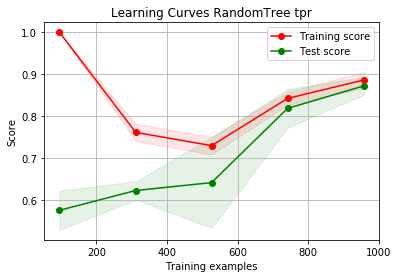

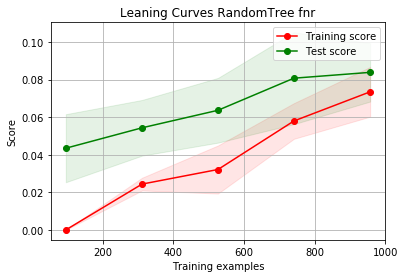

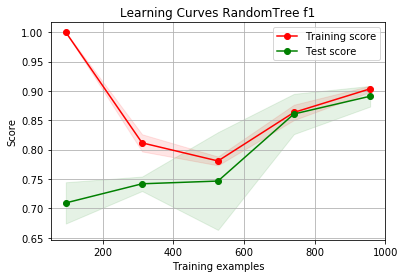

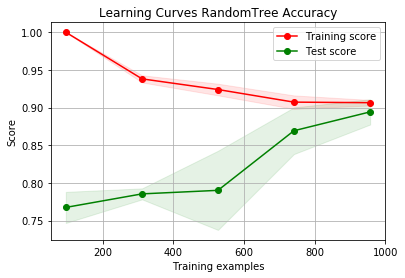

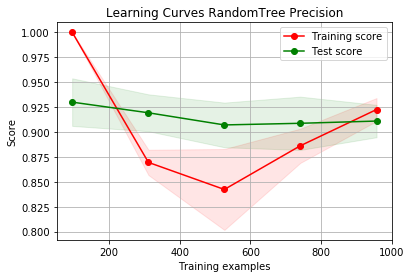

In [34]:
clf = AdaBoostClassifier(n_estimators=10)
cv = StratifiedKFold(n_splits=3, random_state=randint(1,100), shuffle=True)

#recall
print "\n************** RECALL  ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring='recall')
print("TPR-Recall: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores CV: ",scores,"\n"

print "\nTest"
clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = recall_score(y_test, y_pred)
print "Score on test: ",score_test

#fnr
print "\n************** FALSE NEGATIVA RATE  ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring=fnr_scorer )
print("FNR: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores CV: ",scores,"\n"

print "\nTest"
clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = fnr_score(y_test, y_pred)
print "Score on test: ",score_test

#f1
print "\n************** F1 SCORE ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring='f1')
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores cv: ",scores,"\n"

print "\nTest"
clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = f1_score(y_test, y_pred)
print "Score on test: ",score_test

#accuracy
print "\n************** ACCURACY ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring='accuracy')
print("ACC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores cv: ",scores,"\n"

print "\nTest"
clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = accuracy_score(y_test, y_pred)
print "Score on test: ",score_test

#precision
print "\n************** PRECISION ******************"
scores = cross_val_score(clf, X_atrain, y_atrain, cv=cv, scoring='precision')
print("PRESC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print "Scores cv: ",scores,"\n"

clf.fit(X_atrain, y_atrain)
y_pred = clf.predict(X_test)
score_test = precision_score(y_test, y_pred)
print "Score on test: ",score_test #muchis falsos positivos?

####################################################################
print "Learning Curves" 

t1 = "Learning Curves RandomTree tpr"
t2 = "Leaning Curves RandomTree fnr"
t3 = "Learning Curves RandomTree f1"
t4 = "Learning Curves RandomTree Accuracy"
t5 = "Learning Curves RandomTree Precision"

cv = StratifiedKFold(n_splits=4, random_state=randint(1,100), shuffle=True)

plot_learning_curve(clf, t1, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring = 'recall') 
plot_learning_curve(clf, t2, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring= fnr_scorer) 
plot_learning_curve(clf, t3, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring= 'f1') 
plot_learning_curve(clf, t4, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring= 'accuracy') 
plot_learning_curve(clf, t5, X_atrain, y_atrain,  cv=cv, n_jobs=4, scoring= 'precision')
plt.show()


In [3]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

X, y = make_hastie_10_2(random_state=0)
X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)                 


0.91300000000000003